# Chapter 10
## Bet Sizing
Your ML algorithm can achieve high accuracy, but if you do not size your bets properly, your investment strategy will inevitably lose money. In this chapter we will review a few approaches to size bets from ML predictions.

In [58]:
# imports
import numpy as np

from scipy.stats import norm, moment

import pandas as pd
import dask.dataframe as dd
from dask import delayed
from dask.diagnostics import ProgressBar
ProgressBar().register()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import time
import datetime as dt

from EF3M.ef3m import M2N

from IPython.display import display

----
## Exercises
Working our way through the problems. This is intended as a scratchpad and will need to be cleaned up before integration into the codebase.

#### EXERCISE 10.1
Using the formulation in Section 10.3, plot the bet size ($m$) as a function of the maximum predicted probability ($\tilde{p}$) when $||X|| = 2, 3, ..., 10$.

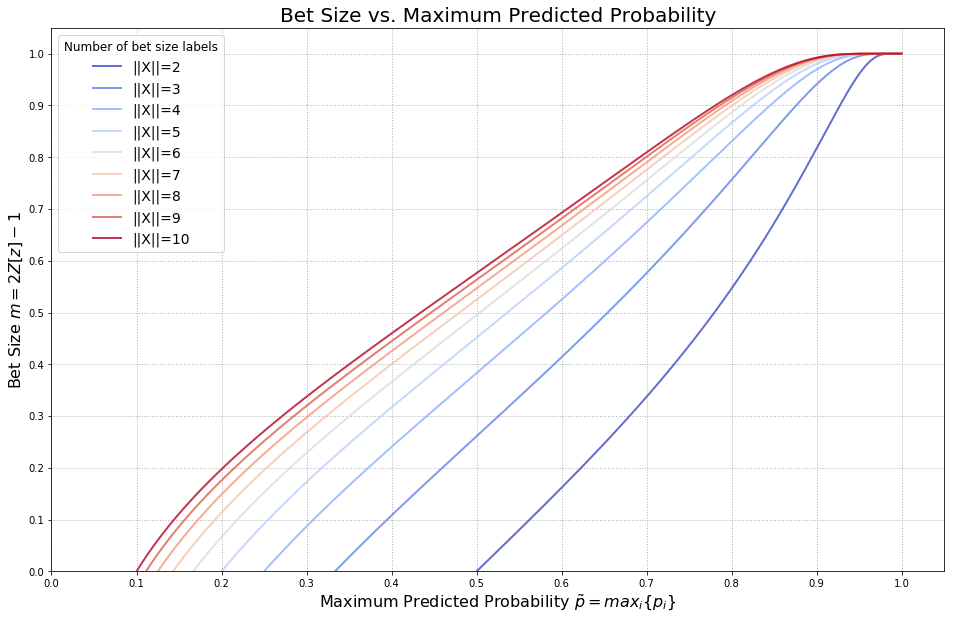

In [2]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10000  # number of points to plot
colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))

fig, ax = plt.subplots(figsize=(16, 10))

for num_classes in num_classes_list:
    min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
    P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
    z = (P - min_prob) / (P*(1-P))**0.5
    m = 2 * norm.cdf(z) - 1
    ax.plot(P, m, label=f"||X||={num_classes}", linewidth=2, alpha=0.8, color=colors.__next__())

ax.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=16)
ax.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=16)
ax.set_title("Bet Size vs. Maximum Predicted Probability", fontsize=20)
ax.set_xticks([0.1*i for i in range(11)])
ax.set_yticks([0.1*i for i in range(11)])
ax.legend(loc="upper left", fontsize=14, title="Number of bet size labels", title_fontsize=12)
ax.set_ylim((0,1.05))
ax.set_xlim((0, 1.05))
ax.grid(linewidth=1, linestyle=':')

plt.show()

----
#### EXERCISE 10.2
Draw 10,000 random numbers from a uniform distribution with bounds U[.5, 1.]. (Author's note: These exercises are intended to simulate dynamic bet sizing of a long-only strategy.)

__(a)__ Compute bet sizes _m_ for $||X||=2$.

__(b)__ Assign 10,000 consecutive calendar days to the bet sizes.

__(c)__ Draw 10,000 random numbers from a uniform distribution with bounds U[1, 25].

__(d)__ Form a `pandas.Series` indexed by the dates in 2.b, and with values equal to the index shifted forward the number of days in 2.c. This is a `t1` object similar to the ones we used in Chapter 3.

__(e)__ Compute the resulting average active bets, following Section 10.4.
 

In [3]:
# draw random numbers from a uniform distribution (all bets are long)
np.random.seed(0)
sample_size = 10_000
P_t = np.random.uniform(.5, 1., sample_size)  # array of random from uniform dist.


# (2.a) Compute bet sizes for ||X||=2
X = [-1, 1]
z = (P_t - 0.5) /  (P_t*(1-P_t))**0.5
m = 2 * norm.cdf(z) - 1  # bet sizes, x=1


# (2.b) assign 10,000 consecutive calendar days
start_date = dt.datetime(2000, 1, 1)
date_step = dt.timedelta(days=1)
dates = np.array([start_date + i*date_step for i in range(sample_size)])
bet_sizes = pd.Series(data=m, index=dates)


# (2.c) draw 10,000 random numbers from a uniform distribution
shift_list = np.random.uniform(1., 25., sample_size)
shift_dt = np.array([dt.timedelta(days=d) for d in shift_list])


# (2.d) create a pandas.Series object
dates_shifted = dates + shift_dt
t1 = pd.Series(data=dates_shifted, index=dates)

# Collect the series into a single DataFrame.
# Add a randomized 'side' indicator so we have both long and short bets.
df_events = pd.concat(objs=[t1, bet_sizes], axis=1)
df_events = df_events.rename(columns={0: 't1', 1: 'bet_size'})
df_events['p'] = P_t
df_events = df_events[['t1', 'p', 'bet_size']]


# (2.e) compute the average active bets
avg_bet = pd.Series()
active_bets = pd.Series()
for idx, val in t1.iteritems():
    active_idx = t1[(t1.index<=idx)&(t1>idx)].index
    num_active = len(active_idx)
    active_bets[idx] = num_active
    avg_bet[idx] = bet_sizes[active_idx].mean()

df_events['num_active_bets'] = active_bets
df_events['avg_active_bets'] = avg_bet


#plt.plot(bet_sizes.index, bet_sizes.values, avg_bet.index, avg_bet.values, alpha=0.6)
display(df_events.head(10))

,t1,p,bet_size,num_active_bets,avg_active_bets
2000-01-01,2000-01-19 23:00:08.486002,0.774407,0.488510,1,0.488510
2000-01-02,2000-01-07 07:47:48.333891,0.857595,0.693816,2,0.591163
2000-01-03,2000-01-13 08:04:38.392503,0.801382,0.550002,3,0.577443
2000-01-04,2000-01-05 21:39:27.736493,0.772442,0.484193,4,0.554130
2000-01-05,2000-01-06 06:47:23.055965,0.711827,0.360002,5,0.515304
2000-01-06,2000-01-30 21:51:01.058622,0.822947,0.602473,5,0.538960
2000-01-07,2000-01-19 17:12:04.590144,0.718794,0.373496,5,0.541659
2000-01-08,2000-01-17 22:17:10.550572,0.945887,0.951258,5,0.593148
2000-01-09,2000-01-14 16:59:42.455288,0.981831,0.999691,6,0.660905
2000-01-10,2000-01-30 08:56:33.839416,0.691721,0.321986,7,0.612488


----
#### EXERCISE 10.3
Using the `t1` object from exercise 2.d:

__(a)__ Determine the maximum number of concurrent long bets, $\bar{c_l}$.

__(b)__ Determine the maximum number of concurrent short bets, $\bar{c_s}$.

__(c)__ Derive the bet size as $m_t = c_{t,l}\frac{1}{\bar{c_l}} - c_{t,s}\frac{1}{\bar{c_s}}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

In [4]:
# (3.a) max number of concurrent long bets
df_events2 = df_events.copy()
active_long = pd.Series()

for idx in df_events2.index:
    df_long_active_idx = set(df_events2[(df_events2.index<=idx)&(df_events2.t1>idx)].index)
    active_long[idx] = len(df_long_active_idx)


print(f"  (3.a) Maximum number of concurrent long bets: {active_long.max()}")

# (3.b) max number of concurrent short bets
# p[x=1]: U[0.5, 1], thus all bets are long, and the 
# number of concurrent short bets is always zero.
print(f"  (3.b)Maximum number of concurrent short bets: {0}")


# (3.c) bet size as difference between fractions of concurrent long and short bets
bet_sizes_2 = active_long/active_long.max() - 0  # number of shorts bets is always 0

df_events2 = df_events2.assign(active_long=active_long,
                               bet_sizes2=bet_sizes_2)
display(df_events2.head(10))

  (3.a) Maximum number of concurrent long bets: 20
  (3.b)Maximum number of concurrent short bets: 0


,t1,p,bet_size,num_active_bets,avg_active_bets,active_long,bet_sizes2
2000-01-01,2000-01-19 23:00:08.486002,0.774407,0.488510,1,0.488510,1,0.05
2000-01-02,2000-01-07 07:47:48.333891,0.857595,0.693816,2,0.591163,2,0.10
2000-01-03,2000-01-13 08:04:38.392503,0.801382,0.550002,3,0.577443,3,0.15
2000-01-04,2000-01-05 21:39:27.736493,0.772442,0.484193,4,0.554130,4,0.20
2000-01-05,2000-01-06 06:47:23.055965,0.711827,0.360002,5,0.515304,5,0.25
2000-01-06,2000-01-30 21:51:01.058622,0.822947,0.602473,5,0.538960,5,0.25
2000-01-07,2000-01-19 17:12:04.590144,0.718794,0.373496,5,0.541659,5,0.25
2000-01-08,2000-01-17 22:17:10.550572,0.945887,0.951258,5,0.593148,5,0.25
2000-01-09,2000-01-14 16:59:42.455288,0.981831,0.999691,6,0.660905,6,0.30
2000-01-10,2000-01-30 08:56:33.839416,0.691721,0.321986,7,0.612488,7,0.35


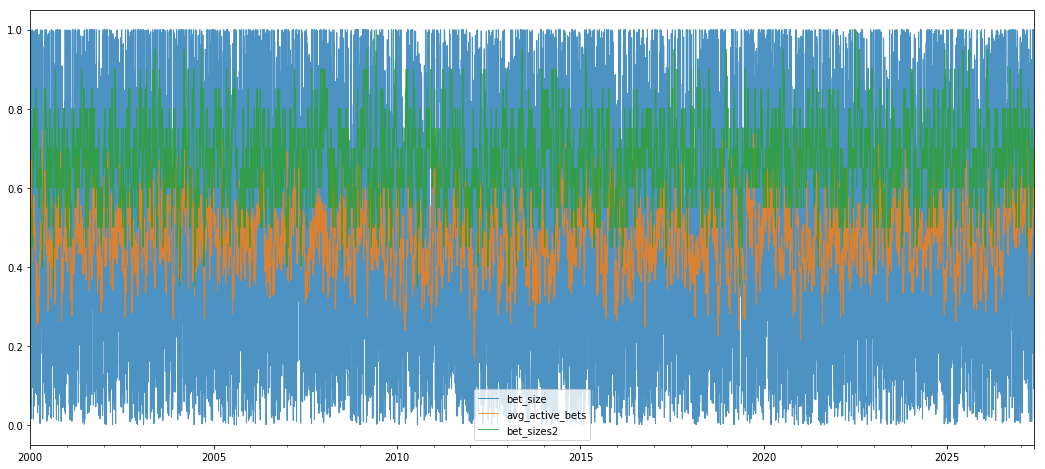

In [5]:
df_events2.plot(y=['bet_size', 'avg_active_bets', 'bet_sizes2'], use_index=True, figsize=(18, 8), alpha=0.8, kind='line', linewidth=1)

----
#### EXERCISE 10.4
Using the `t1` object from exercise 2.d:

__(a)__ Compute the series $c_t = c_{t,l} - c_{t,s}$, where $c_{t,l}$ is the number of concurrent long bets at time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$.

__(b)__ Fit a mixture of two Gaussians on {$c_t$}. You may want to use the method described in López de Prado and Foreman (2014).

__(c)__ Derive the bet size as $$m_t = \begin{cases} \frac{F[c_t]-F[0]}{1-F[0]}, & \text{if } c_t\geq 0\\\
                                                     \frac{F[c_t]-F[0]}{F[0]}, & \text{if } c_t\le 0
\end{cases}$$
where $F[x]$ is the CDF of the fitted mixture of two Gaussians for a value of $x$.

__(d)__ Explain how this series ${m_t}$ differ from the bet size computed in exercise 3.


Mean (first raw moment): 13.375
First 5 centered moments
E[r^1]=0.0
E[r^2]=3.948975
E[r^3]=-0.33733125
E[r^4]=51.253873828125
E[r^5]=-78.8945244140625


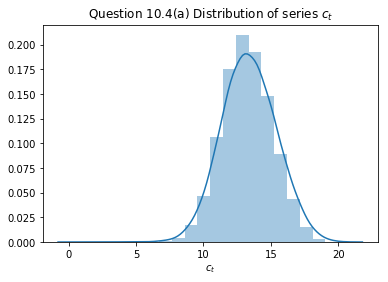

In [74]:
# (4.a) compute the series c_t = c_{t,l}
# ======================================================
df_events2['c_t'] = df_events2.active_long - 0  # number of short bets is always zero
ax = sns.distplot(df_events2['c_t'], bins=20, kde=True, kde_kws={"bw":0.6})
ax.set_xlabel('$c_t$')
ax.set_title("Question 10.4(a) Distribution of series $c_t$")

# (4.b) fit a mixture of 2 Gaussians
# compute the first 5 centered moments
# ======================================================
print(f"Mean (first raw moment): {df_events2.c_t.mean()}")
print("First 5 centered moments")
mmnts = [moment(df_events2.c_t.to_numpy(), moment=i) for i in range(1, 6)]
for i, mnt in enumerate(mmnts):
    print(f"E[r^{i+1}]={mnt}")

In [7]:
# The EF3M algorithm uses the first 5 raw moments, thus
# we need to calculate these from the 5 centered moments
# calculated above.
# ======================================================
import EF3M.ef3m
raw_mmnts = EF3M.ef3m.rawMoment(central_moments=mmnts, dist_mean=df_events2.c_t.mean())
for i, mnt in enumerate(raw_mmnts):
    print(f"E_Raw[r^{i+1}]={mnt}")

E_Raw[r^1]=13.375
E_Raw[r^2]=182.8396
E_Raw[r^3]=2550.7774
E_Raw[r^4]=36273.67
E_Raw[r^5]=525255.703


=== Values chosen based on the mode value of the distribution of results from EF3M (1000 runs) ===
Mode of KDE (mu1): 12.557692518411972
Mode of KDE (mu2): 13.389093517313928
Mode of KDE (sigma1): 3.3499436096599062
Mode of KDE (sigma2): 1.953288672815806
Mode of KDE (p1): 0.013648668609648747


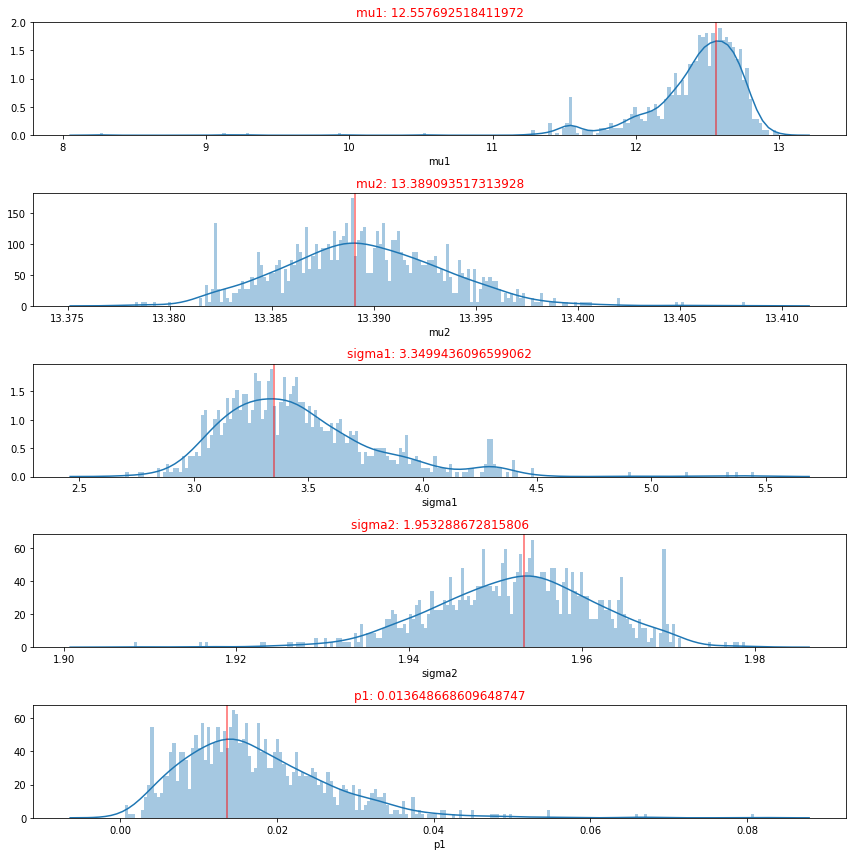

In [70]:
# Now that we have the first 5 raw moments, we can apply the
# EF3M algorithm. We use variant #2 since we have the 5th
# moment, and it converges faster in practice.
# While the first 3 moments are fit exactly, there is not
# a unqiue solution to this we have to make multple runs
# to find the most likely value.
# ======================================================
# uncomment to run the fit, takes about 9 hours for 1000 runs using these parameters
#m2n = EF3M.ef3m.M2N(raw_mmnts)
#df_10_4 = m2n.mpFit(raw_mmnts, epsilon=10**-5, factor=5, n_runs=1000, variant=2, maxIter=10_000_000)
#df_10_4.to_pickle("DF_M2N_fit_10d4_1000runs_type2.pkl")
#print(df_10_4.head(10))


# Here we visualize the results of the 1000 runs, and
# find the most likely value for each parameter from the 
# kernel density estimate of the distribution.
# ======================================================
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(12,12))
cols = ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1']
bins = 250
fit_parameters = []

print("=== Values chosen based on the mode value of the distribution of results from EF3M (1000 runs) ===")

for col_i, ax in enumerate(axs.flatten()):
    col = cols[col_i]
    df = df_10_4.copy()
    df[col+'_bin'] = pd.cut(df[col], bins=bins)
    df = df.groupby([col+'_bin']).count()
    ax = sns.distplot(df_10_4[col], bins=200, kde=True, ax=ax)
    #ax = df_10_4[col].plot.kde()
    dd = ax.get_lines()[0].get_data()
    most_probable_val = dd[0][np.argmax(dd[1])]
    fit_parameters.append(most_probable_val)
    ax.axvline(most_probable_val, color='red', alpha=0.6)
    ax.set_title(f"{col}: {most_probable_val}", color='red')
    print(f"Mode of KDE ({col}):", dd[0][np.argmax(dd[1])])
fig.tight_layout()
plt.show()

The CDF of a [mixture of $n$ distributions](https://en.wikipedia.org/wiki/Mixture_distribution) can be represented as the weighted sum of the individual distributions:
$$ F_{mixture}(x) = \sum_{i=1}^{n}{w_i F_{i, norm}(x)}$$
Where $w_i$ are the weights corresponding to each of the individual cumulative distribution functions of a normal distribution, $F_{i,norm}(x)$.

Thus, for the mixture of $n=2$ distributions in this question, the CDF of the mixture, $F(x)$ is:
$$ F(x) = p_1 F_{norm}(x, \mu_1, \sigma_1) + (1-p_1) F_{norm}(x, \mu_2, \sigma_2) $$
Where $F_{norm}(x, \mu_i, \sigma_i)$ is the cumulative distribution evaluated at $x$ of a Normal distribution with parameters $\mu_i$ and $\sigma_i$.

,bet_size,c_t,bet_sizes2,bet_sizes3
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.473318,13.375000,0.668750,0.498029
std,0.312169,1.987302,0.099365,0.290336
min,0.000058,1.000000,0.050000,0.000003
25%,0.199764,12.000000,0.600000,0.241160
50%,0.429563,13.000000,0.650000,0.422847
75%,0.740689,15.000000,0.750000,0.794848
max,1.000000,20.000000,1.000000,0.999469


20


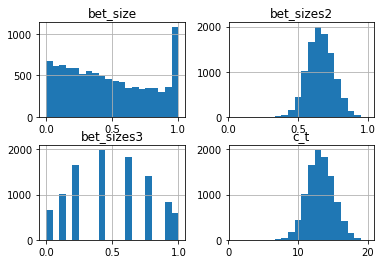

In [106]:
# (4.c) Calculating the bet size using the mixture of 2 Gaussians
# ======================================================

def cdf_mixture(x, parameters):
    # the CDF of a mixture of 2 normal distributions, evaluated at x
    # :param x: (float) x-value
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) CDF of the mixture
    # ===================================
    mu1, mu2, sigma1, sigma2, p1 = parameters  # for clarity
    return p1*norm.cdf(x, mu1, sigma1) + (1-p1)*norm.cdf(x, mu2, sigma2)

def bet_size_mixed(c_t, parameters):
    # return the bet size based on the description provided in
    # question 10.4(c).
    # :param c_t: (int) different of the number of concurrent long bets minus short bets
    # :param parameters: (list) mixture parameters, [mu1, mu2, sigma1, sigma2, p1]
    # :return: (float) bet size
    # =========================
    if c_t >= 0:
        return ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / ( 1 - cdf_mixture(0, parameters) )
    else:
        ( cdf_mixture(c_t, parameters) - cdf_mixture(0, parameters) ) / cdf_mixture(0, parameters)

df_events2['bet_sizes3'] = df_events2.c_t.apply(lambda c: bet_size_mixed(c, fit_parameters))
axs2 = df_events2[['bet_size', 'c_t', 'bet_sizes2', 'bet_sizes3']].hist(bins=20)
display(df_events2[['bet_size', 'c_t', 'bet_sizes2', 'bet_sizes3']].describe())
print(len(df_events2.bet_sizes3.unique()))

4.(d) The bet size distribution calculated in question 3, `bet_sizes2`, 

----
#### EXERCISE 10.5
Repeat exercise 1, where you discretize $m$ with a `stepSize=.01`, `setpSize=.05`, and `stepSize=.1`.

In [ ]:
num_classes_list = [i for i in range(2, 11, 1)]  # array of number of classes, 2 to 10
n = 10000  # number of points to plot


fig, ax = plt.subplots(2, 2, figsize=(20, 16))
ax = fig.get_axes()
d_list = [None, 0.01, 0.05, 0.1]
d = d_list[2]

for i, axi in enumerate(ax):
    colors = iter(cm.coolwarm(np.linspace(0,1,len(num_classes_list))))
    for num_classes in num_classes_list:
        d = d_list[i]
        min_prob, max_prob = 1 / num_classes, 1  # possible range for maximum predicted probability, [1/||X||, 1]
        P = np.linspace(min_prob, max_prob, n, endpoint=False)  # range of maximum predicted probabilities to plot
        z = (P - min_prob) / (P*(1-P))**0.5
        m = 2 * norm.cdf(z) - 1
        if not isinstance(d, type(None)):
            m = (m/d).round()*d
        axi.plot(P, m, label=f"||X||={num_classes}", linewidth=2, alpha=0.8, color=colors.__next__())

    axi.set_ylabel("Bet Size $m=2Z[z]-1$", fontsize=14)
    axi.set_xlabel(r"Maximum Predicted Probability $\tilde{p}=max_i${$p_i$}", fontsize=14)
    axi.set_xticks([0.1*i for i in range(11)])
    axi.set_yticks([0.1*i for i in range(11)])
    axi.legend(loc="upper left", fontsize=10, title="Number of bet size labels", title_fontsize=11)
    axi.set_ylim((0,1.05))
    axi.set_xlim((0, 1.05))
    if not isinstance(d, type(None)):
        axi.set_title(f"Discretized Bet Size, d={d}", fontsize=16)
    else:
        axi.set_title(f"Continuous Bet Size", fontsize=16)
    axi.grid(linewidth=1, linestyle=':')


plt.show()

----
#### EXERCISE 10.6
Rewrite the equations in Section 10.6, so that the bet size is determined by a power function rather than a sigmoid function.

We can substitute a power function to calculate bet size, $\tilde{m}$:

$$\tilde{m}[\omega, x] = sgn[x]|x|^\omega$$

$L[f_i, \omega, \tilde{m}]$, the inverse function of $\tilde{m}[\omega, x]$ with respect to the market price $p_t$, can be rewritten as:

$$L[f_i, \omega, \tilde{m}] = f_i - sgn[\tilde{m}]|\tilde{m}|^{1/\omega}$$

The inverse of $\tilde{m}[\omega, x]$ with respect to $\omega$ can be rewritten as:

$$\omega = \frac{log[|\tilde{m}|]}{log[|x|]}$$

Where $x = f_i - p_t$ is still the divergence between the current market price, $p_t$, and the price forecast, $f_i$.

----
#### EXERCISE 10.7
Modify Snippet 10.4 so that in implements the equations you derived in exercise 6.

In [ ]:
# Snippet 10.4, modified to use a power function for the Bet Size
# ===============================================================
# pos    : current position
# tPos   : target position
# w      : coefficient for regulating width of the bet size function (sigmoid, power)
# f      : forecast price
# mP     : market price
# x      : divergence, f - mP
# maxPos : maximum absolute position size
# ===============================================================

def betSize_power(w, x):
    sgn = np.sign(x)
    return sgn * abs(x)**w

def getTPos_power(w, f, mP, maxPos):
    return int( betSize_power(w, f-mP)*maxPos )

def invPrice_power(f, w, m):
    sgn = np.sign(m)
    return f - sgn*abs(m)**(1/w)

def limitPrice_power(tPos, pos, f, w, maxPos):
    sgn = np.sign(tPos-pos)
    lP = 0
    for j in range(abs(pos+sgn), abs(tPos+1)):
        lP += invPrice_power(f, w, j/float(maxPos))
    lP = lP / (tPos-pos)
    return lP

def getW_sigmoid(x, m):
    return x**2 * (m**-2 - 1)

def getW_power(x, m):
    return np.log(abs(m)) / np.log(abs(x))


In [ ]:
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
w = getW_power(wParams['divergence'], wParams['m'])  # calibrate w

# checking forward and backward calculations
m_test = betSize_power(w, f-mP)
mP_test = invPrice_power(f, w, m_test)
w_test = getW_power(f-mP, m_test)
print(f"Market price: {mP}; Result of inverse price: {mP_test}; Diff: {abs(mP-mP_test)}")
print(f"w: {w}; Result of inverse w: {w_test}; Diff: {abs(w-w_test)}")


In [ ]:
# setup data for replicating Figure 10.3
print("== Bet Sizes vs Price Divergence ==")
mP, f, wParams = 100, 115, {'divergence': 10, 'm': 0.95}
n_points = 1000
X = np.linspace(-1.0, 1.0, n_points)

w = 2
bet_sizes_power = np.array([betSize_power(w, xi) for xi in X])

# plotting
fig, axx = plt.subplots(figsize=(10,8))
axx.plot(X, bet_sizes_power, label='$f[x]=sgn[x]|x|^2$', color='blue', linestyle='-')
axx.set_xlabel("$x$", fontsize=16)
axx.set_ylabel("$f[x]$", fontsize=16)
axx.set_xlim((-1, 1))
axx.set_ylim((-1, 1))
plt.legend(loc='upper left', fontsize=16)
plt.show()